RDD on CN data

# Data sources

From x.com we download the raw data (including notes-00000.tsv)

On HPC we apply the scoring algorithsms, generating output in parquet format

We preprocess and merge these files using

    preprocess_dates.py
    merge_ratings_with_notes.py

# Environment

see requirements.txt or communitynotes2025-05-09.yml

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import calendar
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf



# TODO

add data prep instructions

## RDD

**Research question(s)**: Is it a problem that such a low proportion of notes are rated as helpful ? Restated, at the individual level: Does having a note rated as helpful encourage future contributions, and conversely, does not having a note rated as helpful discourage future contributions. Our unit of analysis is the individuals in the CN system: how are they affected by what happens to their notes?

**Design**: regression discontinuity, comparing notes around threshold for being rated helpful

**Candidate set**: all first-time note authors (yes, most notes might be authored by a minority of repeat authors, but these people are already committed to CN and/or are the people least likely to be influenced by note success, *and* I think the effect on people who have just jointed CN is the one we are most interested in). We will look at the first note of first time note authors only.

(option: we could just look at the first note of 2024, rather than of all time)

**Outcome measure**: does the first time note author go on to author another note? (ie in the rest of 2024).

**Predictors**: there is this issue of notes flip-flopping between helpful and unhelpful. After two weeks a note's status is fixed, and a note author receives notifications each time the note status changes. To create a tractable analysis, consider these two simplifications

A. Final outcome: either Helpful (1) or Unhelpful (0), ignoring all prior status history. We compare notes whose final score was just above and below threshold for this. Call this H

B. Notification occurrence : note author received a notification that the note was rated helpful (1), or never did (0). We compare notes whose maximum all time score was just above or below threshold for this. Call this N

Note that the two predictors define two, distinct, subsets of the candidates (ie you can't just throw both predictors into the same regression, since authors who have a relevant score for H may not have a value for N, and vice versa)

In [2]:
# First let's inmport the data anbd count how many notes we have

rated = pd.read_parquet('/home/zahra/Documents/Tom_Stafford/Community_Notes/analysis/community_notes/data2025post/' + 'rated_notes_compact.parquet', engine='auto')

len(rated) #1,946,619 for 2025 data

1946619

In [5]:
rated['decidedBy'].value_counts(normalize=True)

decidedBy
CoreModel (v1.1)                   0.747396
ExpansionPlusModel (v1.1)          0.111567
ExpansionModel (v1.1)              0.066718
ScoringDriftGuard (v1.0)           0.035042
MultiGroupModel01 (v1.0)           0.029703
NmrDueToMinStableCrhTime (v1.0)    0.005575
GroupModel03 (v1.1)                0.000798
TopicModel01 (v1.0)                0.000510
GroupModel01 (v1.1)                0.000489
GroupModel13 (v1.1)                0.000481
GroupModel09 (v1.1)                0.000400
TopicModel02 (v1.0)                0.000387
GroupModel06 (v1.1)                0.000383
GroupModel02 (v1.1)                0.000156
InsufficientExplanation (v1.0)     0.000132
GroupModel14 (v1.1)                0.000085
GroupModel11 (v1.1)                0.000073
GroupModel10 (v1.1)                0.000046
TopicModel03 (v1.0)                0.000023
GroupModel04 (v1.1)                0.000014
GroupModel07 (v1.1)                0.000010
GroupModel05 (v1.1)                0.000005
GroupModel12 (v1.1)   

In [18]:
# Restricting our analysis to notes after 2024
rated_2024 = rated[(rated.createdAt >= pd.Timestamp(2024, 1, 1))]

# Find the first note written by each author, and if that author goes on to write another note
first_notes = rated.groupby('noteAuthorParticipantId')\
    [['createdAt', 'finalRatingStatus', 'numRatings', 'decidedBy','coreNoteIntercept', 'coreNoteInterceptMax', 'expansionNoteIntercept', 'expansionNoteInterceptMax', 'classification']]\
    .first().reset_index()
# Restricting our analysis to authors who joined in 2024 
first_notes = first_notes[(first_notes.createdAt >= pd.Timestamp(2024, 1, 1)) &
                          (first_notes.createdAt < pd.Timestamp(2025, 1, 1))]
have_another_note = rated_2024[rated_2024.groupby('noteAuthorParticipantId').cumcount() >= 2]\
    ['noteAuthorParticipantId'].to_list()
first_notes['if_written_again'] = first_notes['noteAuthorParticipantId'].isin(have_another_note)
# notes are scored by multiuple algorithms, but nearly 80% are scored by the core model
#  for now  restrict our analysis to thismodel
first_notes = first_notes[first_notes['decidedBy'].isin(['CoreModel (v1.1)', 'ExpansionPlusModel (v1.1)', 'ExpansionModel (v1.1)'])]
# first_notes = first_notes[first_notes['decidedBy'].isin(['CoreModel (v1.1)'])]
# remove NNNs
first_notes = first_notes[first_notes['classification'] != 'NOT_MISLEADING']


In [13]:
rated_2024.columns


Index(['noteId', 'finalRatingStatus', 'classification', 'createdAtMillis',
       'createdAt', 'createdAtYear', 'createdAtMonth', 'numRatings',
       'noteAuthorParticipantId', 'tweetId', 'firstNonNMRStatus',
       'currentStatus', 'mostRecentNonNMRStatus', 'lockedStatus',
       'coreNoteIntercept', 'coreNoteFactor1', 'coreRatingStatus', 'decidedBy',
       'expansionNoteIntercept', 'expansionNoteFactor1',
       'expansionRatingStatus', 'coverageNoteIntercept', 'coverageNoteFactor1',
       'coverageRatingStatus', 'coreNoteInterceptMin', 'coreNoteInterceptMax',
       'expansionNoteInterceptMin', 'expansionNoteInterceptMax',
       'coverageNoteInterceptMin', 'coverageNoteInterceptMax',
       'groupNoteIntercept', 'groupNoteFactor1', 'groupRatingStatus',
       'groupNoteInterceptMax', 'groupNoteInterceptMin', 'modelingGroup',
       'summary', 'isMediaNote'],
      dtype='object')

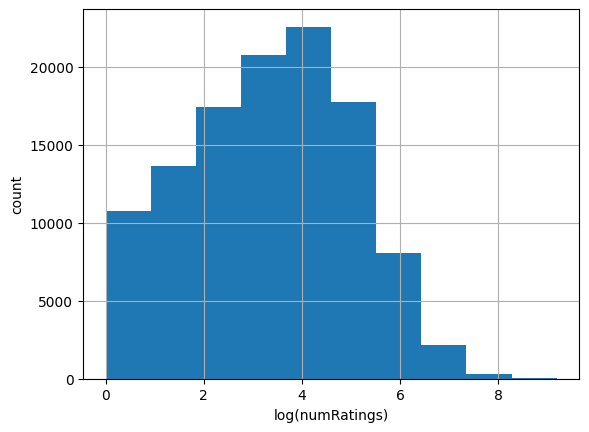

In [6]:
# Most notes have a small number of rating, a small number have very many ratinhgs
# This means the distribution of ratings is very skewed.
# We take the log of the number of ratings to make the distribution more normal


first_notes['log_numRatings']=np.log(first_notes['numRatings'])

first_notes['log_numRatings'].hist() #normal
plt.xlabel('log(numRatings)')
plt.ylabel('count')
plt.show()



In [11]:
first_notes['finalRatingStatus'].value_counts()

finalRatingStatus
NEEDS_MORE_RATINGS             63983
CURRENTLY_RATED_HELPFUL         7290
CURRENTLY_RATED_NOT_HELPFUL     2709
Name: count, dtype: int64

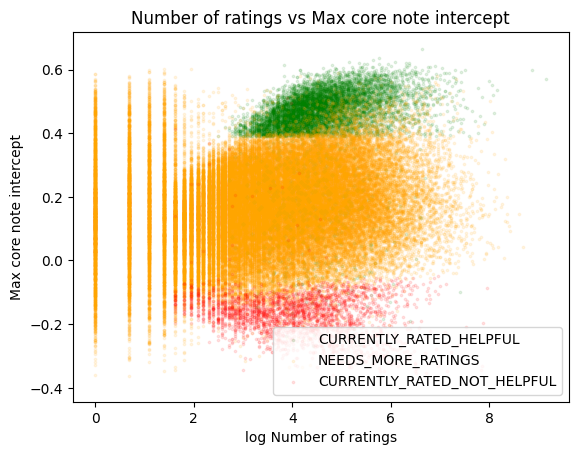

In [9]:
# Plotting log(numRatings) vs coreNoteInterceptMax, with colours according to Note final statuys (finalRatingStatus )  
plt.clf()
groups = ['CURRENTLY_RATED_HELPFUL','NEEDS_MORE_RATINGS','CURRENTLY_RATED_NOT_HELPFUL']
colours=['green','orange','red']

ms=3;alphaval=0.1;

for i in range(3):
    plt.scatter(first_notes[first_notes['finalRatingStatus']==groups[i]]['log_numRatings'], first_notes[first_notes['finalRatingStatus']==groups[i]]['coreNoteIntercept'], s = ms,alpha=alphaval,color=colours[i],label=groups[i])  
    # j+=1

plt.xlabel('log Number of ratings')
plt.ylabel('Max core note intercept')
plt.title('Number of ratings vs Max core note intercept')
plt.legend(loc=0)
plt.savefig('scatter_numRatings_coreNoteIntercept.png',dpi=120,bbox_inches='tight')
plt.show()

#TODO make the legend markers bigger and clearer

# Intepretation:

There is a discontinuity: although some notes labelled NEEDS_MORE_RATINGS have a score above 0.4, no notes with a score below 0.4 have a label CURERENTLY_RATED_HELPFUL

This establishes the logic required for our analaysis

# Now, the RDD

In [19]:
# first_notes dataset is a first_notes for the first notes of authors who 
# wrote their first note in 2024, NNNs were removed


# RDD 
cutoff = 0.4 #threshold at which a note is rated as helpful
bandwidth = 0.2 #window around cutoff

# We fit a model allowing for different intercepts and slopes on either side of the cutoff.

# control, add a column for log number of ratings
first_notes['log_numRatings'] = np.log(first_notes['numRatings'])

# most recent score
running_variable = np.where(
    first_notes["decidedBy"] == "CoreModel (v1.1)",
    first_notes["coreNoteIntercept"],
    first_notes["expansionNoteIntercept"]
) # x value, continuous input


# Treatment = 1 if running_variable >= cutoff, else 0
treatment = np.where(running_variable >= cutoff, 1, 0)

#
outcome_variable = first_notes['if_written_again'].astype(int) # y value, binary output

# we can restrict the analysis to a window (bandwidth) around the cutoff.

mask = (running_variable > cutoff - bandwidth)  & (running_variable < cutoff + bandwidth)

data = pd.DataFrame({
    'running_variable': running_variable[mask],
    'treatment': treatment[mask],
    'outcome_variable': outcome_variable[mask],
    'control' : first_notes[mask]['log_numRatings'],
    'numRatings' : first_notes[mask]['numRatings']
})

# Center the running variable at the cutoff for easier interpretation of the intercept
data['running_variable_centered'] = data['running_variable'] - cutoff
print(f"\nNumber of treated units: {data['treatment'].sum()}")
print(f"Number of control units: {data['treatment'].count() - data['treatment'].sum()}")
# original
rdd_model_formula = 'outcome_variable ~ running_variable_centered * treatment'

rdd_model = smf.ols(formula=rdd_model_formula, data=data).fit()

print("\nRDD Model Summary (using all data):")
print(rdd_model.summary())


Number of treated units: 10568
Number of control units: 27721

RDD Model Summary (using all data):
                            OLS Regression Results                            
Dep. Variable:       outcome_variable   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.072
Date:                Sun, 08 Feb 2026   Prob (F-statistic):             0.0266
Time:                        10:25:02   Log-Likelihood:                -27673.
No. Observations:               38289   AIC:                         5.535e+04
Df Residuals:                   38285   BIC:                         5.539e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------

/home/zahra/Documents/Tom_Stafford/Community_Notes/analysis/community_notes/.env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:

running_variable_max = np.where(
    first_notes["decidedBy"] == "CoreModel (v1.1)",
    first_notes["coreNoteInterceptMax"],
    first_notes["expansionNoteInterceptMax"]
) # x value, continuous input

# Treatment = 1 if running_variable >= cutoff, else 0
treatment = np.where(running_variable_max >= cutoff, 1, 0)

#
outcome_variable = first_notes['if_written_again'].astype(int) # y value, binary output

# we can restrict the analysis to a window (bandwidth) around the cutoff.

mask = (running_variable_max > cutoff - bandwidth)  & (running_variable_max < cutoff + bandwidth)

data = pd.DataFrame({
    'running_variable': running_variable_max[mask],
    'treatment': treatment[mask],
    'outcome_variable': outcome_variable[mask],
    'control' : first_notes[mask]['log_numRatings'],
    'numRatings' : first_notes[mask]['numRatings']
})

# Center the running variable at the cutoff for easier interpretation of the intercept
data['running_variable_centered'] = data['running_variable'] - cutoff
print(f"\nNumber of treated units: {data['treatment'].sum()}")
print(f"Number of control units: {data['treatment'].count() - data['treatment'].sum()}")
# original
rdd_model_formula = 'outcome_variable ~ running_variable_centered * treatment'

rdd_model = smf.ols(formula=rdd_model_formula, data=data).fit()

print("\nRDD Model Summary (using all data):")
print(rdd_model.summary())


Number of treated units: 12449
Number of control units: 31062

RDD Model Summary (using all data):
                            OLS Regression Results                            
Dep. Variable:       outcome_variable   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     9.314
Date:                Sun, 08 Feb 2026   Prob (F-statistic):           3.75e-06
Time:                        10:42:16   Log-Likelihood:                -31485.
No. Observations:               43511   AIC:                         6.298e+04
Df Residuals:                   43507   BIC:                         6.301e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------

In [21]:
# and try it once more for notes which align in their intercept and locked status


# RDD 
cutoff = 0.4 #threshold at which a note is rated as helpful
bandwidth = 0.2 #window around cutoff

# We fit a model allowing for different intercepts and slopes on either side of the cutoff.

# control, add a column for log number of ratings
first_notes['log_numRatings'] = np.log(first_notes['numRatings'])



first_notes['intercept'] = running_variable
# keep when intercept and locked status don't align
notes_filtered = first_notes[
    ((first_notes["intercept"] > 0.4) & (first_notes["finalRatingStatus"] == "CURRENTLY_RATED_HELPFUL")) |
    ((first_notes["intercept"] < 0.4) & (first_notes["finalRatingStatus"] != "CURRENTLY_RATED_HELPFUL"))
]

# most recent score
running_variable = notes_filtered['intercept'] # x value, continuous input

# Treatment = 1 if running_variable >= cutoff, else 0
treatment = np.where(running_variable >= cutoff, 1, 0)

#
outcome_variable = notes_filtered['if_written_again'].astype(int) # y value, binary output

# we can restrict the analysis to a window (bandwidth) around the cutoff.

mask = (running_variable > cutoff - bandwidth)  & (running_variable < cutoff + bandwidth)

data = pd.DataFrame({
    'running_variable': running_variable[mask],
    'treatment': treatment[mask],
    'outcome_variable': outcome_variable[mask],
    'control' : notes_filtered[mask]['log_numRatings'],
    'numRatings' : notes_filtered[mask]['numRatings']
})

# Center the running variable at the cutoff for easier interpretation of the intercept
data['running_variable_centered'] = data['running_variable'] - cutoff
print(f"\nNumber of treated units: {data['treatment'].sum()}")
print(f"Number of control units: {data['treatment'].count() - data['treatment'].sum()}")
# original
rdd_model_formula = 'outcome_variable ~ running_variable_centered * treatment'

rdd_model = smf.ols(formula=rdd_model_formula, data=data).fit()

print("\nRDD Model Summary (using all data):")
print(rdd_model.summary())


Number of treated units: 8258
Number of control units: 27303

RDD Model Summary (using all data):
                            OLS Regression Results                            
Dep. Variable:       outcome_variable   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.324
Date:                Sun, 08 Feb 2026   Prob (F-statistic):           0.000278
Time:                        10:42:24   Log-Likelihood:                -25736.
No. Observations:               35561   AIC:                         5.148e+04
Df Residuals:                   35557   BIC:                         5.151e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------

/home/zahra/Documents/Tom_Stafford/Community_Notes/analysis/community_notes/.env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
first_notes['finalRatingStatus'].unique()

array(['NEEDS_MORE_RATINGS', 'CURRENTLY_RATED_NOT_HELPFUL',
       'CURRENTLY_RATED_HELPFUL'], dtype=object)

In [17]:
#let's see how many notes are in our analysis, around the cutoff

data.groupby('treatment')['numRatings'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,21779.0,105.18550,194.199571,1.0,14.0,40.0,115.0,4258.0
1,8321.0,160.85795,260.497096,1.0,52.0,93.0,179.0,9518.0


In [12]:

# original
rdd_model_formula = 'outcome_variable ~ running_variable_centered * treatment'
#rdd_model_formula = 'outcome_variable ~ running_variable_centered * treatment + control'
rdd_model = smf.ols(formula=rdd_model_formula, data=data).fit()

print("\nRDD Model Summary (using all data):")
print(rdd_model.summary())


RDD Model Summary (using all data):
                            OLS Regression Results                            
Dep. Variable:       outcome_variable   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     7.198
Date:                Mon, 09 Jun 2025   Prob (F-statistic):           8.02e-05
Time:                        10:36:28   Log-Likelihood:                -6441.5
No. Observations:                8969   AIC:                         1.289e+04
Df Residuals:                    8965   BIC:                         1.292e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [13]:
# The coefficient for 'treatment' is the estimated effect at the cutoff.
estimated_effect = rdd_model.params['treatment']
print(f"\nEstimated Treatment Effect at the Cutoff: {estimated_effect:.4f}")

print("I think we can intepret this as a % change the chance of authoring again if published")

p_value_treatment = rdd_model.pvalues['treatment']
t_statistic_treatment = rdd_model.tvalues['treatment']
conf_int_treatment = rdd_model.conf_int().loc['treatment']

# print out p value and t-statistic for treatment
print(f"\nP-value for treatment: {p_value_treatment:.4f}")
print(f"T-statistic for treatment: {t_statistic_treatment:.4f}")
print(f"Confidence interval for treatment: " + str(conf_int_treatment))




Estimated Treatment Effect at the Cutoff: 0.0442
I think we can intepret this as a % change the chance of authoring again if published

P-value for treatment: 0.0328
T-statistic for treatment: 2.1353
Confidence interval for treatment: 0    0.003627
1    0.084846
Name: treatment, dtype: float64


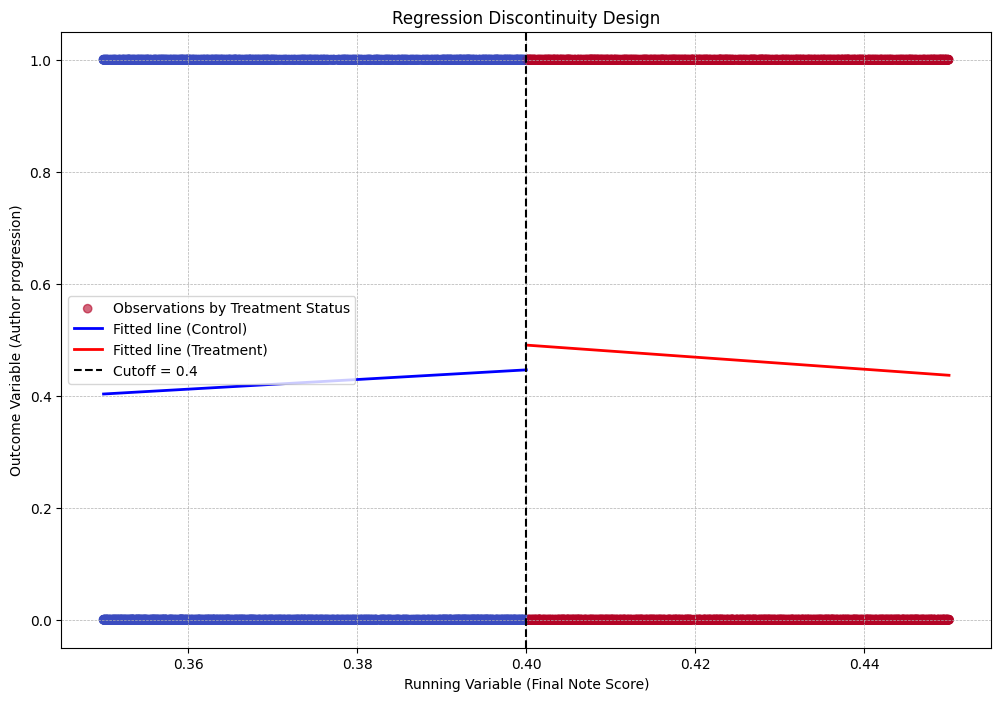

In [14]:
# 3. Visualization
plt.figure(figsize=(12, 8))
plt.scatter(data['running_variable'], data['outcome_variable'],
            c=data['treatment'], cmap='coolwarm', alpha=0.6, label='Observations by Treatment Status')

# Plot regression lines for each side of the cutoff
# For values below the cutoff (treatment=0)
x_below = np.linspace(data['running_variable'].min(), cutoff, 100)
y_below = rdd_model.params['Intercept'] + rdd_model.params['running_variable_centered'] * (x_below - cutoff)

# For values above the cutoff (treatment=1)
x_above = np.linspace(cutoff, data['running_variable'].max(), 100)
y_above = (rdd_model.params['Intercept'] + rdd_model.params['treatment']) + \
          (rdd_model.params['running_variable_centered'] + rdd_model.params['running_variable_centered:treatment']) * (x_above - cutoff)

plt.plot(x_below, y_below, color='blue', linestyle='-', linewidth=2, label='Fitted line (Control)')
plt.plot(x_above, y_above, color='red', linestyle='-', linewidth=2, label='Fitted line (Treatment)')

plt.axvline(x=cutoff, color='black', linestyle='--', label=f'Cutoff = {cutoff}')
plt.xlabel('Running Variable (Final Note Score)')
plt.ylabel('Outcome Variable (Author progression)')
plt.title('Regression Discontinuity Design')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('plots/RDD.png',bbox_inches='tight',dpi=120)
plt.show()



# Sensitivity analysis

Our main result is an effect of 0.0540, with a p-value of 0.0071

To rest the robustness of these results we rerun with different threshold (original 0.04)

0.100:
0.050: Effect of 0.054, p-value 0.0071
0.025:

